## Анализ данных, проблемы, способы их решения

В рассматриваемой задаче данных относительно немного, поэтому чтобы компенсировать нехватку данных для обучения слоев, выделяющих общие паттерны, используем предобученную модель Inception v3 с последующем дообучением, заменив слои для классификации на нужное число классов (auxiliary output и final output). Также данные сильно несбалансированы, поэтому примерно уравняем число объектов в каждом классе, размножив объекты в кажом классе до значения как в классе с максимальным числом объектов. Засчет рандомности аугментаций в каком-то смысле так раскопированные объекты можно считать как новые изображения. Будем использовать только отражения и повороты. Так как изображения взяты из мультфильма (не реальные снимки), то они не страдают тенями, нехваткой освещенности, шумами, поэтому не будем добавлять аугментации цвета, шума, контрастности, яркости и т.д., чтобы не путать модель. Более того цвета в данной задаче более менее стабильны в датасете, поэтому они как раз могу быть важны и характерны для определения принадлежности к классу конкретного персонажа. 
Обучение организуем в три этапа: сначала замораживаем модель кроме слоя классификатора, чтобы получить некоторое предварительное распределение; затем обучим модель на несбалансированных данных; после на сбалансированных. Второй шаг обусловлен тем, что модель на сбалансированных данных учиться долго (потому что их просто больше).

В данной задаче уже с такой подготовкой данных получается достаточно высокий скор по метрике f1 на тесте: 0.99787.

Вообще был такой прогресс: без ребалансировки c Resnet18: 0.99043 -> c ребалансировкой c Resnet18: 0.99574 -> c ребалансировкой c Inception v3: 0.99787

## Решение

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torchsummary

import numpy as np
import matplotlib.pyplot as plt

import time
import copy
import pickle
from PIL import Image
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

torch.manual_seed(13)

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0
Torchvision Version:  0.7.0


In [2]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Константы

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 299x299 px
RESCALE_SIZE = 299

# объявляем "рабочий" девайс, на котором будет происходить обучение
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# количество классов в нашем датасете
NUM_CLASSES=42

# в процессе обучения будем сохранять параметры модели, оптимизатора и прочее
# сюда
PARAM_PATH = './springfield_classification_ft_inception_v3.pth'

## Подготовка датасета

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image = image.convert("RGB")
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        # print(self.files[index])
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(45),
                transforms.RandomHorizontalFlip(),
                #transforms.ColorJitter(hue=.05),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
              ])
        else:
            transform = transforms.Compose([
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        # print(x.shape)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

## Изучение датасета

In [6]:
TRAIN_DIR = Path('./train/simpsons_dataset')
TEST_DIR = Path('./testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [7]:
len(train_val_files)

20933

In [8]:
len(test_files)

991

In [9]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

In [10]:
from collections import Counter
traindata_view = dict(Counter(train_labels).most_common())

Ключевая проблема - сильный дисбаланс классов

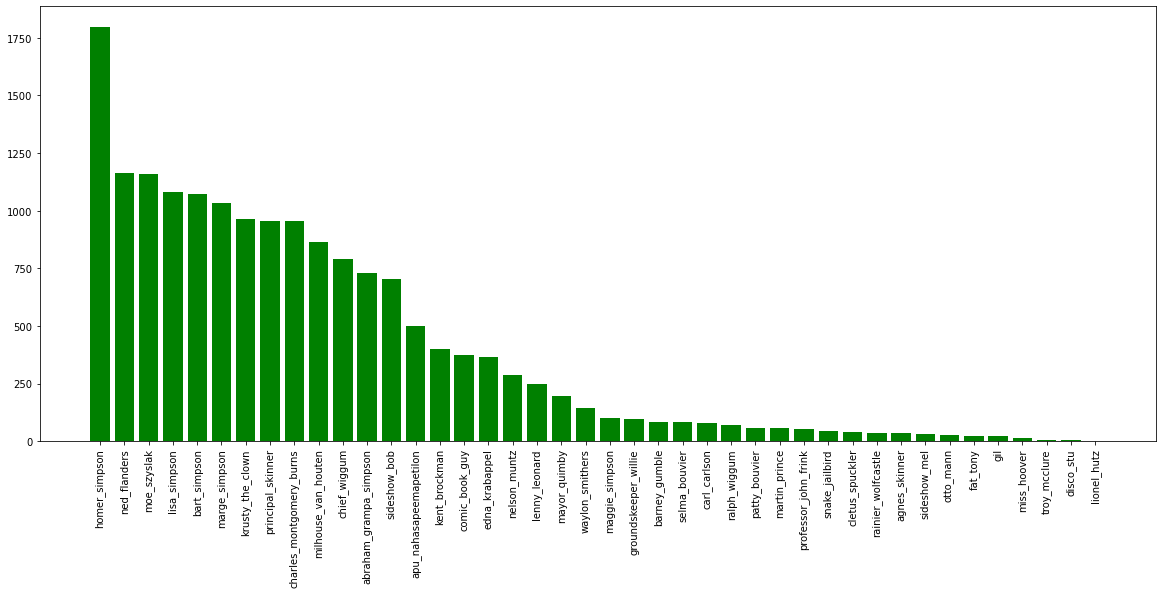

In [11]:
plt.figure(figsize=(20,8))
plt.bar(traindata_view.keys(), traindata_view.values(), color='g')
ticks = plt.xticks(rotation=90)

In [12]:
# train_dataset = SimpsonsDataset(train_files, mode='train')
# fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
#                         sharey=True, sharex=True)
# for fig_x in ax.flatten():
#     random_characters = int(np.random.uniform(0,8))
#     im_val, label = train_dataset[random_characters]
#     img_label = " ".join(map(lambda x: x.capitalize(),\
#                 train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
#     imshow(im_val.data.cpu(), \
#           title=img_label,plt_ax=fig_x)

## Ребалансировка классов

In [13]:
# Эта функция возвращает словарь, в котором названию класса ставятся в
# соответствие адреса картинок, принадлежащих этому классу
def create_dct_path_labels(train_files, train_labels):
    result = {}
    for label in np.unique(train_labels).tolist():
        result[label] = []

    for path, label in zip(train_files, train_labels):
        result[label].append(path)

    return result

In [14]:
# Получим максимальное количество картинок в классе на данный момент
max_num_of_entries = list(traindata_view.values())[0]

In [15]:
supplemented_paths_by_labels = create_dct_path_labels(train_files, train_labels)

In [16]:
# Создаем копии
for label in supplemented_paths_by_labels.keys():
    curr_len = len(supplemented_paths_by_labels[label])
    if curr_len != max_num_of_entries:
        ratio = max_num_of_entries // curr_len
        if ratio > 1:
            supplemented_paths_by_labels[label] = supplemented_paths_by_labels[label] * ratio
        else:
            supplemented_paths_by_labels[label] = supplemented_paths_by_labels[label] * 2

In [17]:
balanced_data_view = {}
for key in supplemented_paths_by_labels.keys():
    balanced_data_view[key] = len(supplemented_paths_by_labels[key])

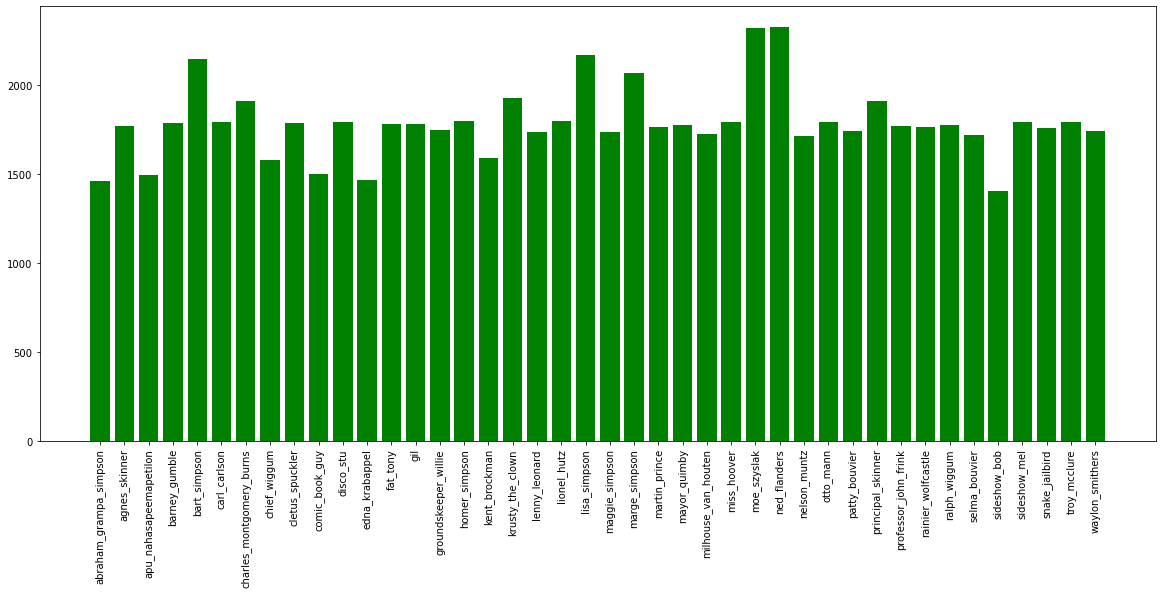

In [18]:
plt.figure(figsize=(20,8))
plt.bar(balanced_data_view.keys(), balanced_data_view.values(), color='g')
ticks = plt.xticks(rotation=90)

In [19]:
suppl_to_flat = (list(supplemented_paths_by_labels.values()))
train_files = [item for sublist in suppl_to_flat for item in sublist]

### Создаем тестовый и валидационный датасеты

In [20]:
val_dataset = SimpsonsDataset(val_files, mode='val')    
train_dataset = SimpsonsDataset(train_files, mode='train')

## Модель

Будем обучать предобученную inception_v3. Функция ниже отвечает за обучение и сохранение параметров во время обучения.

In [21]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, param_path,
                num_epochs=25, is_inception=False, resume=False, new_layers=False):
    
    since = time.time()

    history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0
    curr_epoch = 0

    if resume:
        checkpoint = torch.load(param_path)
        curr_epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        history = checkpoint['history']

        model.load_state_dict(checkpoint['model_state_dict'])
        if not new_layers:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        best_model_wts = copy.deepcopy(checkpoint['best_model_wts'])

        print("Resuming training from: \nEpoch: {ep:03d} \
        \ntrain loss: {tl:0.4f} train acc: {ta:0.4f} val loss: {vl:0.4f} val acc: {va:0.4f} \
        \nBest acc: {ba:0.4f}".format(
            ep=curr_epoch, tl=history[-1][0][0], ta=history[-1][0][1],
            vl=history[-1][1][0], va=history[-1][1][1], ba=best_acc
        ))

    num_epochs -= curr_epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        history.append([])

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            history[-1].append((epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print('-'*30)
        scheduler.step(history[-1][1][0])

        print("Saving parameters...")
        torch.save({
            'epoch': epoch,
            'best_acc': best_acc,
            'best_model_wts': best_model_wts,
            'history': history,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
        }, param_path)
        print("Parameters saved successfully\n")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [22]:
# Функция, отвечающая за предсказания
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [23]:
# Функция, позволяющая замораживать/размораживать параметры модели
def set_parameter_requires_grad(model, set_to):
    for param in model.parameters():
        param.requires_grad = set_to

In [24]:
# Загружаем предобученную модель
model = models.inception_v3(pretrained=True)

Обучение в два этапа:
1.   Обучение классификатора, только последний слой.
2.   Обучение всей модели.

In [25]:
set_parameter_requires_grad(model, set_to=False)
# Handle the auxilary net
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, NUM_CLASSES)
# Handle the primary net
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,NUM_CLASSES)

In [26]:
# Send the model to GPU
model = model.to(DEVICE)

batch_size = 50

if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

dataloaders_dict = {
    'train': DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=False)
}

Будем обучать модель, используя:

*   AdamW с amsgrad=True и начальным lr=1e-3
*   nn.CrossEntropyLoss
*   Для уменьшения lr со временем будем использовать ReduceLROnPlateau 

In [211]:
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [214]:
# START_LR = 1e-8

# opt = torch.optim.AdamW(params_to_update, lr=START_LR, amsgrad=True)
# criterion = nn.CrossEntropyLoss()
# criterion = criterion.to(DEVICE)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     opt, patience=3,threshold=1e-2, verbose=True
# )

# END_LR = 10
# NUM_ITER = 100

# lr_finder = LRFinder(model, opt, criterion, DEVICE)
# lrs, losses = lr_finder.range_test(dataloaders_dict["train"], END_LR, NUM_ITER)

In [216]:
FOUND_LR = 1e-2

opt = torch.optim.AdamW(model.fc.parameters(), lr=FOUND_LR, amsgrad=True)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, patience=3, threshold=1e-2, verbose=True
)

## Обучение

### Обучение классификатора

In [217]:
model, history = train_model(
    model, dataloaders_dict, criterion, opt, scheduler,
    PARAM_PATH, num_epochs=10, is_inception=True,
    resume=False
)

Epoch 0/9
----------
train Loss: 4.6601 Acc: 0.2859
val Loss: 2.2476 Acc: 0.4020
------------------------------
Saving parameters...
Parameters saved successfully

Epoch 1/9
----------
train Loss: 3.9227 Acc: 0.3897
val Loss: 2.2371 Acc: 0.3989
------------------------------
Saving parameters...
Parameters saved successfully

Epoch 2/9
----------
train Loss: 4.0079 Acc: 0.3943
val Loss: 2.1845 Acc: 0.4385
------------------------------
Saving parameters...
Parameters saved successfully

Epoch 3/9
----------
train Loss: 4.0407 Acc: 0.3981
val Loss: 2.0833 Acc: 0.4349
------------------------------
Saving parameters...
Parameters saved successfully

Epoch 4/9
----------
train Loss: 4.0640 Acc: 0.4049
val Loss: 2.0566 Acc: 0.4492
------------------------------
Saving parameters...
Parameters saved successfully

Epoch 5/9
----------
train Loss: 4.1752 Acc: 0.3951
val Loss: 2.1182 Acc: 0.4674
------------------------------
Saving parameters...
Parameters saved successfully

Epoch 6/9
------

## Обучение всей модели целиком

In [27]:
set_parameter_requires_grad(model, set_to=True)

In [28]:
FOUND_LR = 3e-4

opt = torch.optim.AdamW(model.parameters(), lr=FOUND_LR, amsgrad=True)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3,
                                                       factor=0.7,
                                                       threshold=1e-2,
                                                       verbose=True)

In [30]:
model, history = train_model(
    model, dataloaders_dict, criterion, opt, scheduler,
    PARAM_PATH, num_epochs=1, is_inception=True,
    resume=True, new_layers=True
)

Resuming training from: 
Epoch: 027         
train loss: 0.0002 train acc: 0.9999 val loss: 0.0949 val acc: 0.9900         
Best acc: 0.9900
Training complete in 0m 1s
Best val Acc: 0.989969


## Визуализация  обучения

In [31]:
loss, acc, val_loss, val_acc = [], [], [], []
for i in range(len(history)):
    loss.append(history[i][0][0])
    acc.append(history[i][0][1])
    val_loss.append(history[i][1][0])
    val_acc.append(history[i][1][1])

In [32]:
acc = torch.stack(acc).cpu().detach().numpy()
val_acc = torch.stack(val_acc).cpu().detach().numpy()

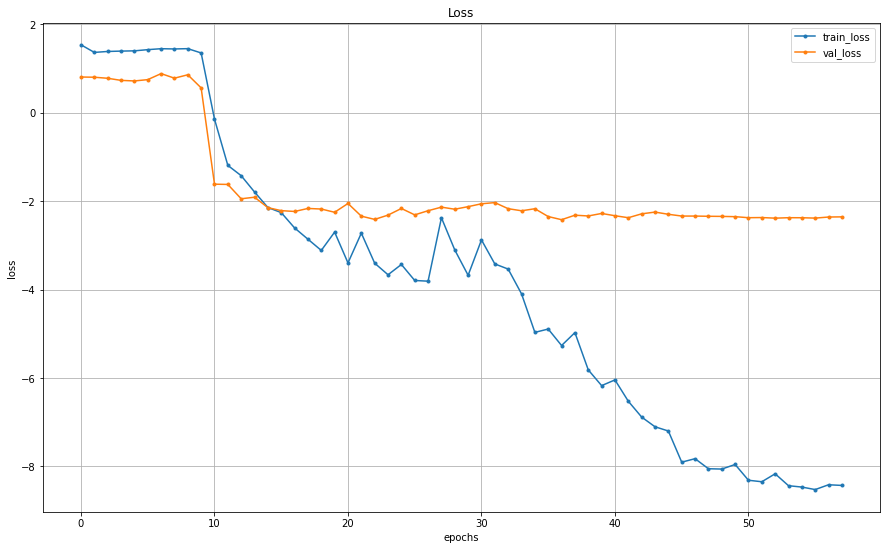

In [55]:
plt.figure(figsize=(15, 9))
plt.plot(np.log(loss), marker='o', markersize=3, label="train_loss")
plt.plot(np.log(val_loss), marker='o', markersize=3, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('Loss')
plt.grid()
plt.show()

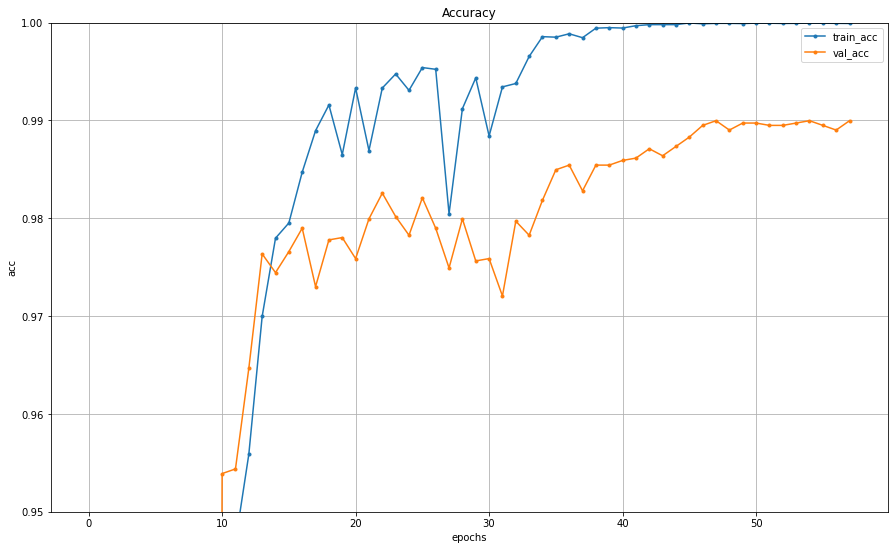

In [34]:
plt.figure(figsize=(15, 9))
plt.plot(acc, marker='o', markersize=3, label="train_acc")
plt.plot(val_acc, marker='o', markersize=3, label="val_acc")
plt.ylim([0.95, 1])
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.title('Accuracy')
plt.grid()
plt.show()

## Анализ результатов

In [35]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
val_view_dataset = SimpsonsDataset(val_files, mode="test")
val_view_loader = DataLoader(val_view_dataset, shuffle=False, batch_size=32)
probs = predict(model, val_view_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

In [36]:
encode_preds = np.argmax(probs, axis=1)

In [37]:
actual_labels = [val_dataset[id][1] for id in range(len(val_dataset))]

In [38]:
from sklearn.metrics import f1_score
f1_score(actual_labels, encode_preds, average='micro')

0.989968951516599

In [39]:
mistakes = np.where((encode_preds == actual_labels) == False)[0].tolist()

In [40]:
len(mistakes)

42

In [41]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=14, ncols=3,figsize=(80, 80), \
                        sharey=True, sharex=True)
cnt = 0
for fig_x in ax.flatten():
    random_characters = mistakes[cnt]
    cnt+=1
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

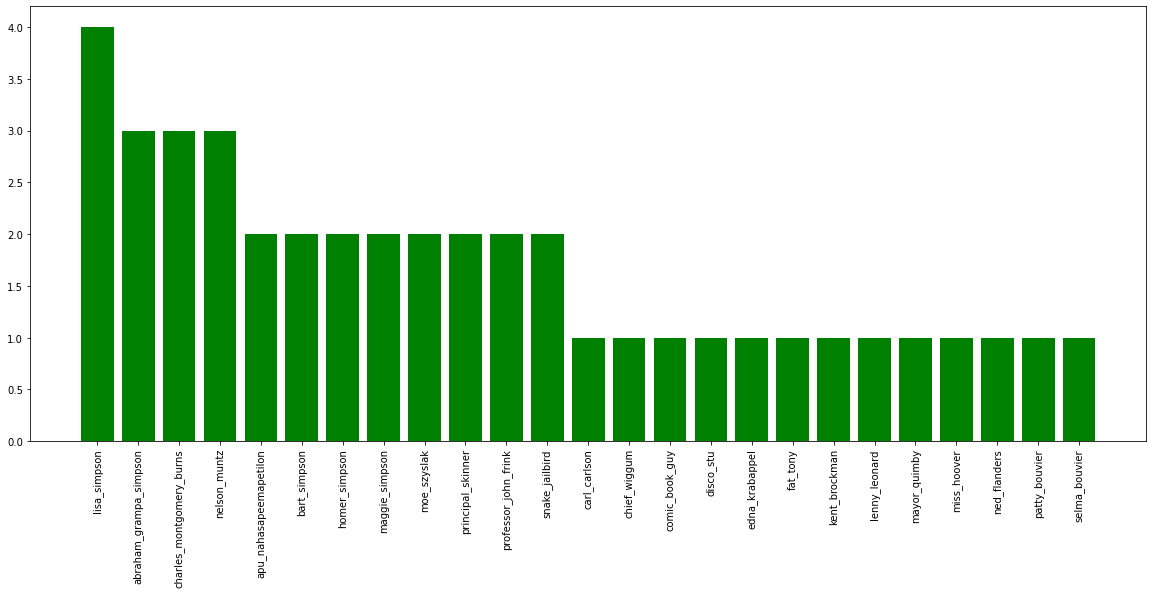

In [44]:
actual_wrong = dict(Counter(label_encoder.inverse_transform(np.array(actual_labels)[mistakes])).most_common())
plt.figure(figsize=(20,8))
plt.bar(actual_wrong.keys(), actual_wrong.values(), color='g')
ticks = plt.xticks(rotation=90)

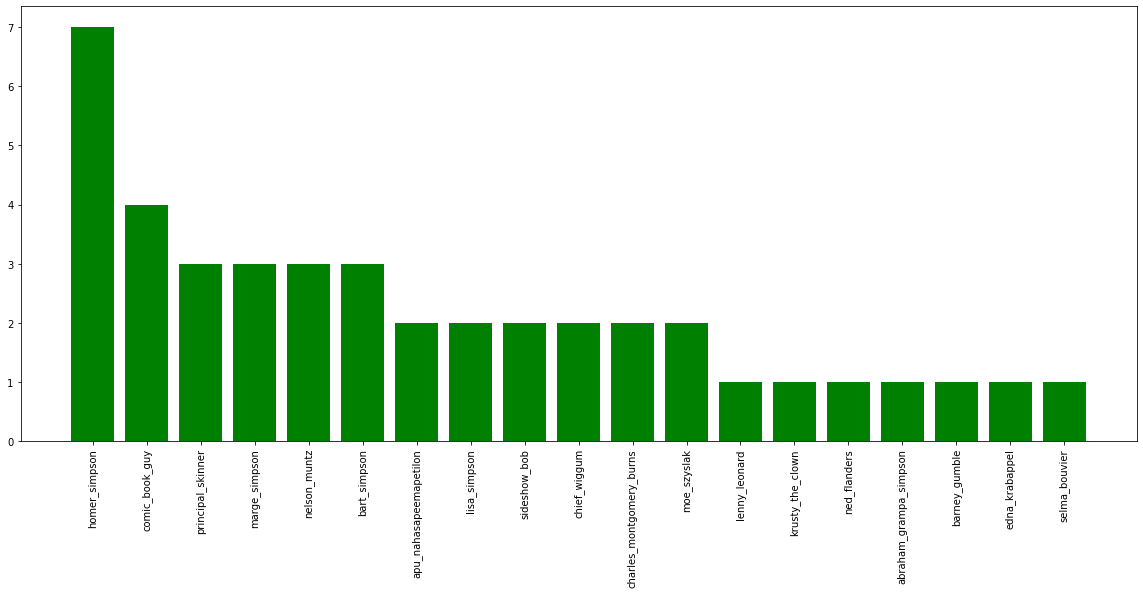

In [48]:
pred_wrong = dict(Counter(label_encoder.inverse_transform(encode_preds[mistakes])).most_common())
plt.figure(figsize=(20,8))
plt.bar(pred_wrong.keys(), pred_wrong.values(), color='g')
ticks = plt.xticks(rotation=90)

In [49]:
pred_wrong_values = []
for key in pred_wrong.keys():
    pred_wrong_values.append(traindata_view.get(key))

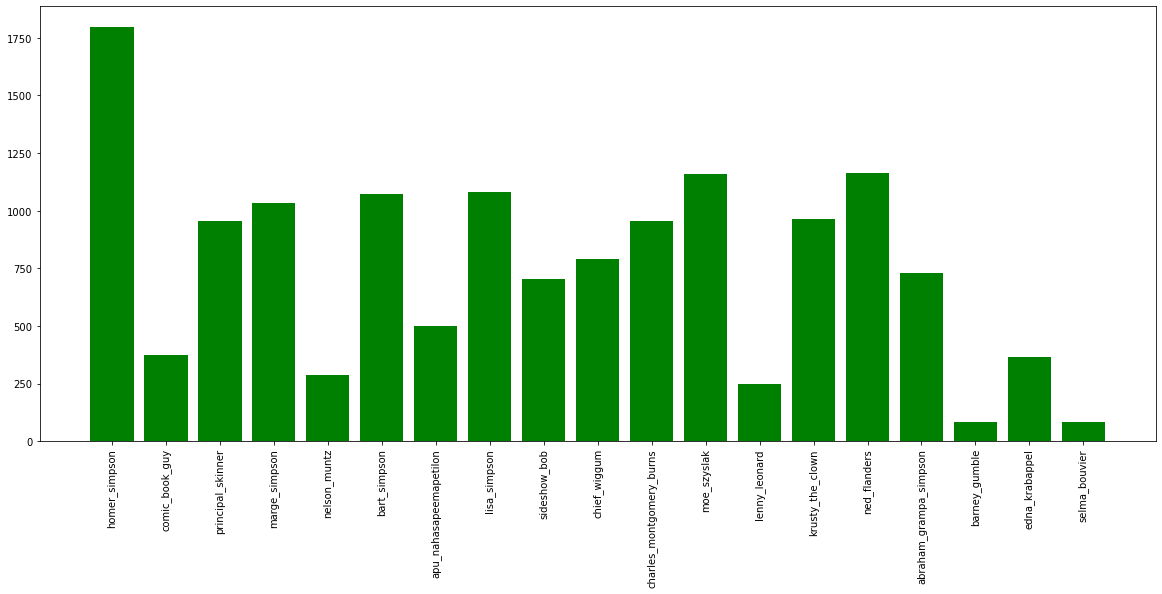

In [50]:
plt.figure(figsize=(20,8))
plt.bar(pred_wrong.keys(), pred_wrong_values, color='g')
ticks = plt.xticks(rotation=90)

## Submit

In [51]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [52]:
checkpoint = torch.load(PARAM_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['best_model_wts'])

<All keys matched successfully>

In [53]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [54]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('submission.csv', index=False)